In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import  keras

import wordcloud

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

import emoji

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



import pandas as pd
import seaborn as sns
import string 
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

2023-06-20 08:42:48.054074: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 08:42:51.072826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 08:42:51.087623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 08:42:57.461377: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/brijesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brijesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df1 = pd.read_csv("./datasets/sms.csv",delimiter=',')
df2 = pd.read_csv("datasets/yt.csv",delimiter=',')
df3 = pd.read_csv("datasets/my-collection.csv",delimiter=',')
df4 = pd.read_csv("datasets/spam-word.csv",delimiter=',')

df = pd.concat([df1,df2,df3,df4])


df = df[["Comment", "Spam"]]


df = df.drop_duplicates()
df = df.dropna()
df["Spam"]  = df["Spam"].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20553 entries, 0 to 644
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  20553 non-null  object
 1   Spam     20553 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 481.7+ KB


Preprocessing

In [3]:
spam_words = [ "Urgent", "Exclusive", "Limited time", "Free", "Guaranteed", "Act now", "Discount", "Special offer", "Prize", "Instant",    "Cash", "Save", "Win", "Best", "Secret", "Incredible", "Congratulations", "Approved", "Risk free", "Hidden", "Bonus",    "Sale", "Amazing", "Extra cash", "Opportunity", "Easy", "Double your", "Best price", "Cash back", "Deal", "Earn",    "Money", "No obligation", "Profit", "Results", "Exciting", "Unbelievable", "Jackpot", "Fantastic", "Instant access",    "Million dollars", "Discounted", "Last chance", "Exclusive offer", "Big savings", "Limited offer", "Free trial",    "Special promotion", "Secret revealed", "Valuable", "Money-back guarantee", "Lowest price", "Save money", "Make money",    "No risk", "Exclusive deal", "Limited supply", "Huge", "Incredible offer", "Prize winner", "Earn extra income",    "Limited spots", "New offer", "Best deal", "Don't miss out", "Great savings", "Top offer", "Double your income",    "Discount code", "Fast cash", "Top-rated", "Best value", "No cost", "Elite", "Act fast", "Unbeatable", "Cash prize",    "Limited availability", "Special discount", "Quick cash", "No catch", "Instant approval", "Big discount", "Easy money",    "Insider", "Invitation", "Free shipping", "Huge discount", "Extra income", "Secret formula", "No strings attached",    "Money-making", "Dream come true", "Massive", "Free gift", "Incredible opportunity", "Risk-free trial", "Instant money",    "Special price", "No purchase necessary"]


In [4]:
pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
df['Comment'] = df['Comment'].apply(lambda text: " ".join([word.lower() for word in pattern.sub('', text.lower().strip()).split() if word.lower() not in set(stopwords.words('english'))]))

In [5]:
df['length'] = df['Comment'].str.len().astype(int)
df['currency']=df['Comment'].str.contains('₤|₨|€|₹|₿|$',regex=False).astype(int)
df['spam_word']=df['Comment'].str.contains('|'.join(i.lower().strip() for i in spam_words ),regex=True).astype(int)
df["emoji"] = df['Comment'].str.contains('💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥').astype(int)


In [6]:


# df["emoji"] = df['Comment'].str.contains('💭|🔝|🆗|🎉|🎊|📯|🙌|😂|💸|👉|📢|🚀|💲|💣|🔱|💼|🆙|⏳|✨|💌|💎|🆕|🔞|💡|💰|👑|⭐|🌟|🎤|⚡|📈|💵|🏆|💪|🔓|🆓|🎰|⌚|🚨|💢|📮|🔥|🎈|🎥|🔔|💯|🎶|🔗|🎁|📚|🔊|👍|👏|📱|📝|🤑|🏅|🔒|📣|💥').astype(int)

# df["flag"] = df['Comment'].str.contains('🇦🇫|🇦🇱|🇩🇿|🇦🇩|🇦🇴|🇦🇷|🇦🇲|🇦🇼|🇦🇺|🇦🇹|🇦🇿|🇧🇸|🇧🇭|🇧🇩|🇧🇧|🇧🇾|🇧🇪|🇧🇿|🇧🇯|🇧🇲|🇧🇹|🇧🇴|🇧🇦|🇧🇼|🇧🇷|🇧🇳|🇧🇬|🇧🇫|🇧🇮|🇨🇻|🇰🇭|🇨🇲|🇨🇦|🇮🇨|🇰🇾|🇨🇫|🇹🇩|🇨🇱|🇨🇳|🇨🇽|🇨🇨|🇨🇴|🇰🇲|🇨🇬|🇨🇩|🇨🇰|🇨🇷|🇨🇮|🇭🇷|🇨🇺|🇨🇼|🇨🇾|🇨🇿|🇩🇰|🇩🇯|🇩🇲|🇩🇴|🇪🇨|🇪🇬|🇸🇻|🇬🇶|🇪🇷|🇪🇪|🇪🇹|🇫🇰|🇫🇴|🇫🇯|🇫🇮|🇫🇷|🇬🇫|🇵🇫|🇹🇫|🇬🇦|🇬🇲|🇬🇪|🇩🇪|🇬🇭|🇬🇮|🇬🇷|🇬🇱|🇬🇩|🇬🇵|🇬🇺|🇬🇹|🇬🇬|🇬🇳|🇬🇼|🇬🇾|🇭🇹|🇭🇳|🇭🇰|🇭🇺|🇮🇸|🇮🇳|🇮🇩|🇮🇷|🇮🇶|🇮🇪|🇮🇲|🇮🇱|🇮🇹|🇯🇲|🇯🇵|🇯🇪|🇯🇴|🇰🇿|🇰🇪|🇰🇮|🇽🇰|🇰🇼|🇰🇬|🇱🇦|🇱🇻|🇱🇧|🇱🇸|🇱🇷|🇱🇾|🇱🇮|🇱🇹|🇱🇺|🇲🇴|🇲🇰|🇲🇬|🇲🇼|🇲🇾|🇲🇻|🇲🇱|🇲🇹|🇲🇭|🇲🇶|🇲🇷|🇲🇺|🇾🇹|🇲🇽|🇫🇲|🇲🇩|🇲🇨|🇲🇳|🇲🇪|🇲🇸|🇲🇦|🇲🇿|🇲🇲|🇳🇦|🇳🇷|🇳🇵|🇳🇱|🇳🇨|🇳🇿|🇳🇮|🇳🇪|🇳🇬|🇳🇺|🇳🇫|🇲🇵|🇰🇵|🇳🇴|🇴🇲|🇵🇰|🇵🇼|🇵🇸|🇵🇦|🇵🇬|🇵🇾|🇵🇪|🇵🇭|🇵🇳|🇵🇱|🇵🇹|🇵🇷|🇶🇦|🇷🇴|🇷🇺|🇷🇼|🇧🇱|🇸🇭|🇰🇳|🇱🇨|🇲🇫|🇵🇲|🇻🇨|🇼🇸|🇸🇲|🇸🇹|🇸🇦|🇸🇳|🇷🇸|🇸🇨|🇸🇱|🇸🇬|🇸🇽|🇸🇰|🇸🇮|🇸🇧|🇸🇴|🇿🇦|🇬🇸|🇰🇷|🇸🇸|🇪🇸|🇱🇰|🇸🇩|🇸🇷|🇸🇯|🇸🇿|🇸🇪|🇨🇭|🇸🇾|🇹🇼|🇹🇯|🇹🇿|🇹🇭|🇹🇱|🇹🇬|🇹🇰|🇹🇴|🇹🇹|🇹🇳|🇹🇷|🇹🇲|🇹🇨|🇹🇻|🇺🇬|🇺🇦|🇦🇪|🇬🇧|🇺🇸|🇺🇾|🇺🇿|🇻🇺|🇻🇦|🇻🇪|🇻🇳|🇻🇮|🇻🇬|🇼🇫|🇪🇭|🇾🇪|🇿🇲|🇿🇼').map({False:0,True:1})

df['contain']=df['Comment'].str.contains('[0-9]*%|T&C',regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains(r"https?://\S+|www\.\S+",regex=True).astype(int)
df['contain']=df['contain'] | df['Comment'].str.contains("free|Free").astype(int)

df['email']=df['Comment'].str.contains(r"[\w]+@[\w]+\.\w+",regex=True).astype(int)
df['phone']=df['Comment'].str.contains(r"\+?[0-9]?[0-9]? ?0?[0-9]{10}",regex=True).astype(int)


df

,Comment,Spam,length,currency,spam_word,emoji,contain,email,phone
0,go jurong point crazy available bugis n great ...,0,82,0,0,0,0,0,0
1,ok lar joking wif u oni,1,23,0,0,0,0,0,0
2,free entry 2 wkly comp win fa cup final tkts 2...,1,135,0,1,0,1,0,1
3,u dun say early hor u c already say,0,35,0,0,0,0,0,0
4,nah dont think goes usf lives around though,0,43,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
640,youve targeted scam click report,1,32,0,0,0,0,0,0
641,youve victim identity theft click learn,1,39,0,1,0,0,0,0
642,youve struck lottery jackpot click collect mas...,1,61,0,1,0,0,0,0
643,youve free gift card click claim prize,1,38,0,1,0,1,0,0


Remove

In [7]:
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"(\+[0-9]{2})? ?\d{10}").sub(r"", text) )
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"[\w]+@[\w]+\.\w+").sub(r"", text) )
df["Comment"] = df["Comment"].map(lambda  text :  re.compile(r"https?://\S+|www\.\S+").sub(r"", text))
df["Comment"] = df["Comment"].map(lambda  text :  emoji.replace_emoji(text))

wordlem=nltk.WordNetLemmatizer()

df["Comment"] = df["Comment"].map(lambda text : " ".join([wordlem.lemmatize(i.strip()) for i in re.split("\W+",text) ]))
df["Comment"] = df["Comment"].map(lambda  text :  text.strip() )


In [8]:
y=pd.DataFrame(df.Spam)
x=df.drop(["Spam", "currency" , "spam_word" , "emoji" , "contain", "email", "phone"],axis=1)

In [9]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2,random_state=0)


In [10]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(x_train['Comment'])

train_string_sequences = tokenizer.texts_to_sequences(x_train['Comment'])
test_string_sequences = tokenizer.texts_to_sequences(x_test['Comment'])

max_string_sequence_length = 5000
train_string_data = pad_sequences(train_string_sequences, maxlen=max_string_sequence_length)
test_string_data = pad_sequences(test_string_sequences, maxlen=max_string_sequence_length)


In [11]:
# # input_data = {column: x_train[column].values for column in x_train.columns}
# # input_data_test = {column: x_val[column].values for column in x_val.columns}
X_train=[train_string_data,x_train["length"]]
X_test=[test_string_data, x_test["length"]]


In [13]:


string_input = tf.keras.layers.Input(shape=(max_string_sequence_length,), dtype=tf.int32)
numerical_input = tf.keras.layers.Input(shape=(1,))


# Define layers for string input
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=500, input_length=max_string_sequence_length)(string_input)
flatten_layer = tf.keras.layers.Flatten()(embedding_layer)

# Define layers for numerical input
numerical_dense = tf.keras.layers.Dense(64, activation='relu')(numerical_input)



# Concatenate all input branches
concat_layer = tf.keras.layers.concatenate([flatten_layer, numerical_dense])

# Add dense and output layers
dense_layer = tf.keras.layers.Dense(64, activation='relu')(concat_layer)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(dense_layer)

# Create the model
model = tf.keras.Model(inputs=[string_input, numerical_input], outputs=output_layer)


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.build(input_shape=[])

2023-06-20 09:00:08.758123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 09:00:08.759873: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-20 09:00:10.909755: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 640016384 exceeds 10% of free system memory.
2023-06-20 09:00:11.320154: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 640016384 exceeds 10% of free s

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [92]:
model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
377/514 [=====================>........] - ETA: 1:23 - loss: 0.3101 - accuracy: 0.9275

KeyboardInterrupt: 

In [64]:

model = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(model, dtype=tf.string, trainable=True,name="hub")

# nnlm_model = tf.saved_model.load("./models/nnlm-en-dim50_2")

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(8,1),name="Input_layer"),   
    embed,
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build()
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.binary_crossentropy, metrics=['accuracy'])
print(model.summary())X_train

TypeError: The added layer must be an instance of class Layer. Received: layer=<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f8e1f137a10> of type <class 'tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject'>.

In [23]:
from tensorflow.keras.utils import plot_model

# Plot model
plot_model(model, to_file='team_strength_model.png')

# Display the image
data = plt.imread('team_strength_model.png')
plt.imshow(data);

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


FileNotFoundError: [Errno 2] No such file or directory: 'team_strength_model.png'

In [140]:
x_train

,Comment,length,currency,spam_word,emoji,contain,email,phone
14060,eeeaten,7,1,0,0,0,0,0
4064,ha wouldnt say didnt read anything way u seeme...,89,1,1,0,0,0,0
11325,ignoramous,10,1,0,0,0,0,0
8761,derren brown video horseracing,30,1,0,0,0,0,0
8033,0050 puzzle solved minor 0o well thats oddly s...,67,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...
7954,what s better secure method encryption asymmet...,85,1,0,0,0,0,0
14480,nice video though nfts need smart contract you...,132,1,0,0,0,0,0
4676,wow,3,1,0,0,0,0,0
5630,dependency blockchain,23,1,0,0,0,0,0


In [14]:
model.fit(X_train,
          y_train,
          epochs=3,
          batch_size=32,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)]
)


2023-06-20 09:01:06.214411: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 328840000 exceeds 10% of free system memory.


Epoch 1/3


2023-06-20 09:01:07.805201: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 640016384 exceeds 10% of free system memory.


514/514 [==============================] - 1515s 3s/step - loss: 1.0900 - accuracy: 0.9145 - val_loss: 0.5196 - val_accuracy: 0.9243
Epoch 2/3
514/514 [==============================] - 1505s 3s/step - loss: 0.4656 - accuracy: 0.9194 - val_loss: 0.4138 - val_accuracy: 0.9243
Epoch 3/3
108/514 [=====>........................] - ETA: 19:39 - loss: 0.4092 - accuracy: 0.9204

In [17]:
model.evaluate([X_test],y_test)

129/129 [==============================] - 37s 275ms/step - loss: 0.1417 - accuracy: 0.9243


[0.1417188197374344, 0.924349308013916]

In [31]:
cv=CountVectorizer(max_features=5000)
temp_train=cv.fit_transform(x_train['Comment']).toarray()
temp_val=cv.transform(x_val['Comment']).toarray()

tf=TfidfTransformer()
temp_train=tf.fit_transform(temp_train)
temp_val=tf.transform(temp_val)

temp_train=pd.DataFrame(temp_train.toarray(),index=x_train.index)
temp_val=pd.DataFrame(temp_val.toarray(),index=x_val.index)
x_train=pd.concat([x_train,temp_train],axis=1,sort=False)
x_val=pd.concat([x_val,temp_val],axis=1,sort=False)

x_train.drop(['Comment'],axis=1,inplace=True)
x_val.drop(['Comment'],axis=1,inplace=True)



In [36]:
x_train.columns = x_train.columns.astype(str)
x_val.columns = x_val.columns.astype(str)        

In [37]:
y_train=y_train.astype(int)
y_val=y_val.astype(int)

In [39]:
model=MultinomialNB()
model.fit(x_train,y_train)
y_preds=model.predict(["dad"])
print("Multinomial Naive Bayes:",accuracy_score([1],y_preds))

/home/brijesh/.local/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/brijesh/.local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=['dad'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [114]:
model=DecisionTreeClassifier(random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Decision Tree:",accuracy_score(y_val,y_preds))

Decision Tree: 0.953782534663099


In [115]:
model=RandomForestClassifier(n_estimators=100,random_state=0)
model.fit(x_train,y_train)
y_preds=model.predict(x_val)
print("Random Forest:",accuracy_score(y_val,y_preds))

/tmp/ipykernel_1921/2502017040.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train,y_train)


Random Forest: 0.9778642666018


In [ ]:
training_size = int(len(df) * 0.8)
vocab_size=50000
embedding_dim=32
max_length=1000


training_sentences = df["Comment"][0:training_size]
testing_sentences = df["Comment"][training_size:]
training_labels = df["Spam"][0:training_size]
testing_labels = df["Spam"][training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<00V>")
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=1000, padding="post", truncating="post")

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=1000, padding="post", truncating="post")

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),

    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

2023-06-18 23:24:57.945584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-18 23:24:58.044037: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          1600000   
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                        

In [ ]:
num_epochs = 10

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/10
514/514 - 13s - loss: 0.2194 - accuracy: 0.9555 - val_loss: 0.5757 - val_accuracy: 0.7796 - 13s/epoch - 25ms/step
Epoch 2/10
514/514 - 12s - loss: 0.2039 - accuracy: 0.9555 - val_loss: 0.6010 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 3/10
514/514 - 13s - loss: 0.1943 - accuracy: 0.9555 - val_loss: 0.6258 - val_accuracy: 0.7796 - 13s/epoch - 24ms/step
Epoch 4/10
514/514 - 12s - loss: 0.1886 - accuracy: 0.9555 - val_loss: 0.6488 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 5/10
514/514 - 12s - loss: 0.1853 - accuracy: 0.9555 - val_loss: 0.6687 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 6/10
514/514 - 12s - loss: 0.1835 - accuracy: 0.9555 - val_loss: 0.6853 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step
Epoch 7/10
514/514 - 13s - loss: 0.1825 - accuracy: 0.9555 - val_loss: 0.6987 - val_accuracy: 0.7796 - 13s/epoch - 24ms/step
Epoch 8/10
514/514 - 12s - loss: 0.1821 - accuracy: 0.9555 - val_loss: 0.7078 - val_accuracy: 0.7796 - 12s/epoch - 24ms/step


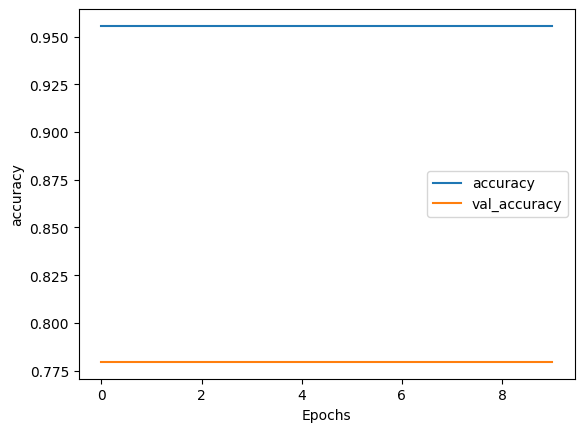

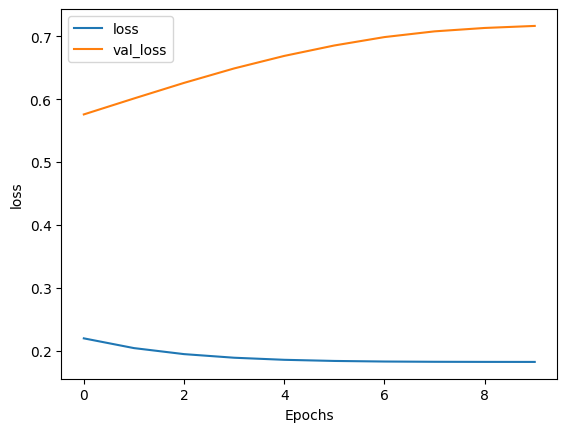

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
# sequences = tokenizer.texts_to_sequences(sentence)
# padded = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
print(model.evaluate(testing_padded,testing_labels))

129/129 [==============================] - 0s 2ms/step - loss: 0.7165 - accuracy: 0.7796
[0.7164579033851624, 0.7796156406402588]
